# Creating training dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from get_data import cat_dog_data

splits, info = cat_dog_data()

(train, valid, test) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

from preprocess_data import format_image
from configuration_file import BATCH_SIZE

train_dataset = train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = valid.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = test.map(format_image).batch(1)

# Creating Model

In [2]:
from creating_model import build_model

In [3]:
model = build_model()

In [4]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [5]:
import numpy as np

In [6]:
np.arange(0,10)[:-4]

array([0, 1, 2, 3, 4, 5])

In [6]:
len(model.trainable_variables)

8

In [7]:
# choose the optimizer
optimizer = tf.keras.optimizers.RMSprop(0.001)

# configure the model for training
model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])

In [8]:
from configuration_file import EPOCHS

In [9]:

model.fit(train_dataset,
          epochs=EPOCHS,
          validation_data=valid_dataset)

Epoch 1/3
582/582 [==============================] - 34s 59ms/step - loss: 1.0025 - accuracy: 0.6854 - val_loss: 0.2237 - val_accuracy: 0.9329
Epoch 2/3
582/582 [==============================] - 34s 58ms/step - loss: 0.2047 - accuracy: 0.9280 - val_loss: 0.1254 - val_accuracy: 0.9467
Epoch 3/3
582/582 [==============================] - 34s 59ms/step - loss: 0.1426 - accuracy: 0.9506 - val_loss: 0.1500 - val_accuracy: 0.9377


## Model Interpretability

Let's now go through the steps to generate the class activation maps. You will start by specifying the layers you want to visualize.


In [10]:
model.save('trained_model2.h5')

In [128]:
#model = tf.keras.models.load_model('trained_model.h5')

In [11]:
outputs = [layer.output for layer in model.layers[1:18]]

In [12]:
outputs

[<tf.Tensor 'block1_conv1/Relu:0' shape=(None, 224, 224, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Relu:0' shape=(None, 224, 224, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/MaxPool:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(None, 112, 112, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu:0' shape=(None, 112, 112, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/MaxPool:0' shape=(None, 56, 56, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Relu:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/MaxPool:0' shape=(None, 28, 28, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(None, 28, 28, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Relu:0' shape=(None, 28, 28, 512) dtype=float32>,
 <tf.Tensor 'block4_conv3/Relu:0' shape=(None, 28, 28, 512) dtype=float32>,

In [13]:
vis_model = tf.keras.models.Model(inputs=model.input, outputs= outputs)

In [14]:
layer_names = []
for layer in outputs:
    print(layer.name.split('/')[0])
    layer_names.append(layer.name.split('/')[0])

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3


In [15]:
layer_names

['block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3']

In [16]:

len(layer_names)

17

In [17]:
from preprocess_data import preprocess_image

In [18]:
len(test_dataset)

2326

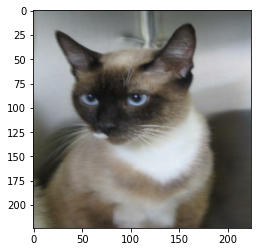

In [19]:
for img, label in  test_dataset.take(1):
    plt.imshow(img[0])
    preprocessed_image= preprocess_image(img[0])
    

In [20]:
cam_model = tf.keras.models.Model(inputs=[model.inputs],
                                 outputs=[model.get_layer('block5_conv3').output,
                                         model.output])

In [21]:
conv_output, results= cam_model.predict(preprocessed_image)

In [22]:
results

array([[1.000000e+00, 8.218294e-35]], dtype=float32)

In [24]:
results[:,1]

array([0.], dtype=float32)

In [25]:
actual_label = label[0]

In [26]:
actual_label = tf.cast(actual_label, tf.float32)

In [27]:
actual_label

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [28]:
np.argmax(results)

0

In [29]:
results[0]

array([1., 0.], dtype=float32)

In [23]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

In [26]:
#model_grad = Model([model.inputs], 
                       #[model.get_layer(layer_name).output, model.output])
with tf.GradientTape() as tape:
    conv_output, results = cam_model(preprocessed_image)
    tape.watch(conv_output)
   
    pred_prob = results[:,1]
    actual_label = tf.cast(actual_label, dtype=tf.float32)
    #loss_func = tf.keras.losses.BinaryCrossentropy()
    #loss = loss_func(actual_label,
                   # pred_prob)
    smoothing = 0.00001 
        
        # Calculate loss as binary cross entropy
    loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
    print(f"binary loss: {loss}")
    print(f'binary_loss = {loss}')



grad_values = tape.gradient(loss, conv_output)
grad_values = K.mean(grad_values, axis=(0, 1, 2))

binary loss: [-1.001353e-05]
binary_loss = [-1.001353e-05]


In [28]:
grad_values.numpy().max()

8.333064e-38

In [67]:
grad_values.min()

0.0

In [29]:
preprocessed_image.shape

(1, 224, 224, 3)

In [30]:
conv_output.shape

TensorShape([1, 14, 14, 512])

In [31]:
conv_output.shape[-1]

512

In [32]:
conv_output = np.squeeze(conv_output.numpy())

In [33]:
conv_output.shape

(14, 14, 512)

In [34]:

grad_values = grad_values.numpy()

In [35]:
grad_values.shape

(512,)

In [36]:
for i in range(512):
    conv_output[:,:,i] *= grad_values[i]
heatmap = np.mean(conv_output, axis=-1)

In [37]:
heatmap.shape

(14, 14)

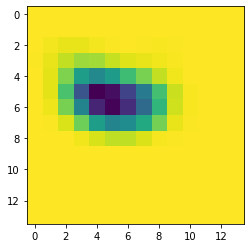

In [38]:
plt.imshow(heatmap)

In [39]:
heatmap = np.maximum(heatmap, 0)

In [40]:
heatmap.shape

(14, 14)

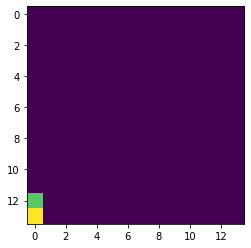

In [41]:
plt.imshow(heatmap)

In [42]:
heatmap /= heatmap.max()

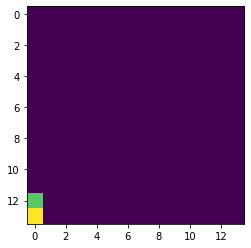

In [43]:
plt.imshow(heatmap)

In [44]:
import cv2

In [45]:
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

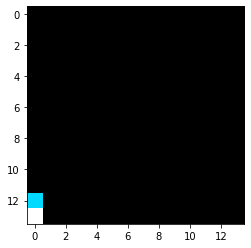

In [46]:
plt.imshow(heatmap)